In [11]:
import sys,os,os.path
sys.path.append("../../")
sys.path.append(os.path.expanduser('~/code/eol_hsrl_python'))
os.environ['ICTDIR']='/home/e78368jw/Documents/NEXT_CODE/IC'

#%load_ext autoreload
#%autoreload 2
#%matplotlib notebook

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'
rcParams['figure.figsize'] = [10, 8]
rcParams['font.size'] = 22

import pandas as pd
import numpy  as np
import tables as tb

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.colors as clrs

import IC.invisible_cities.core.core_functions                   as     coref
import IC.invisible_cities.io.dst_io                           as     dstio

from IC.invisible_cities.cities                 import beersheba as beerfun


from IC.invisible_cities.database.load_db       import DataSiPM

from IC.invisible_cities.evm.event_model        import Cluster, Hit
from IC.invisible_cities.types.ic_types         import xy
from IC.invisible_cities.reco.paolina_functions import voxelize_hits

from IC.invisible_cities.evm.event_model        import HitEnergy
from IC.invisible_cities.cities.beersheba          import DeconvolutionMode
from IC.invisible_cities.cities.beersheba          import CutType


from IC.invisible_cities.reco.deconv_functions import deconvolve
from IC.invisible_cities.reco.deconv_functions import deconvolution_input
from IC.invisible_cities.reco.deconv_functions import InterpolationMethod

import IC.invisible_cities.io.mcinfo_io as mcio


import matplotlib.cm as cm
from matplotlib.colors import Normalize

In [12]:
# Input file and some event IDs to look at.
dist = 12
typefile = 'esmeralda' #'esmeralda'
#file = f'/Users/halmamol/NEXT/files/NEXT100/separated/esmeralda/esmeralda_10_sep.h5'
file = f'../data/data/0nubb/only_separated_tracks/esmeralda/esmeralda_22_sep.h5'
#file = f'/Users/halmamol/NEXT/files/FLEX/ELdistMask/Xe/bb0nu/{typefile}/NextFlex.bb0nu.FLEXELdist{dist}mask.0.detsim.h5'
evts = [90] #15, 30, 90
pitch = 15.55
detector_db     = 'localdb.NEXT100DB.sqlite3'
run_number      = -1

datatype = 'data'


# Parameters involved in beersheba city and the deconvolution.

deconv_params = dict(
  q_cut           = 4, #5 for 6mm  - 5 for 6mm
  drop_dist       = [16, 16],
  #psf_fname       = f'/Users/halmamol/NEXT/PSF_FLEX100_mask{dist}_lowQE.h5',     
  psf_fname       = '/home/e78368jw/Documents/NEXT_CODE/next_misc/0nubb_LPR/LightTables/NEXT100_PSF_kr83m_5bar.h5',     
  e_cut           = 0.05, #15 for 6mm  - 15 for 6mm
  n_iterations    = 100, #150 for 6mm  - 150 for 6mm
  iteration_tol   = 1e-10,
  sample_width    = [15.55, 15.55],
  bin_size        = [ 1,  1],
  diffusion       = (1., 0.2),
  n_dim           = 2,
  deconv_mode     = DeconvolutionMode.joint,
  satellite_params = None,
  energy_type     = HitEnergy.Ec,
  cut_type        = CutType.rel)
 # inter_method    = InterpolationMethod.cubic)
#satellite_params = dict(satellite_start_iter = 75,
#                        satellite_max_size   = 3,
#                        e_cut                = 0.2,
#                        cut_type             = CutType.rel)
                
deconv_params_   = {k : v for k, v in deconv_params.items() if k not in ['q_cut', 'drop_dist']}

# Couple of functions used in beersheba.

cut_sensors       = beerfun.cut_over_Q   (deconv_params['q_cut'    ], ['E', 'Ec'])
drop_sensors      = beerfun.drop_isolated(deconv_params['drop_dist'], ['E', 'Ec'])

In [13]:
deconv_params

{'q_cut': 4,
 'drop_dist': [16, 16],
 'psf_fname': '/home/e78368jw/Documents/NEXT_CODE/next_misc/0nubb_LPR/LightTables/NEXT100_PSF_kr83m_5bar.h5',
 'e_cut': 0.05,
 'n_iterations': 100,
 'iteration_tol': 1e-10,
 'sample_width': [15.55, 15.55],
 'bin_size': [1, 1],
 'diffusion': (1.0, 0.2),
 'n_dim': 2,
 'deconv_mode': <DeconvolutionMode.joint: 'joint'>,
 'satellite_params': None,
 'energy_type': <HitEnergy.Ec: 'Ec'>,
 'cut_type': <CutType.rel: 'rel'>}

## City Flow

#### Input SiPM Signal

SiPM signal which the city takes (esmeralda hits). 

In [14]:
if(typefile == 'esmeralda'): hdst = dstio.load_dst(file, 'CHITS', 'lowTh')#CHITS/lowTh
elif(typefile == 'penthesilea'): hdst = dstio.load_dst(file, 'RECO', 'Events')#CHITS/lowTh

OSError: ``/home/e78368jw/Documents/NEXT_CODE/next_misc/data/data/0nubb/only_separated_tracks/esmeralda/esmeralda_22_sep.h5`` does not exist

In [15]:
hdst = pd.read_hdf('/home/e78368jw/Documents/NEXT_CODE/next_misc/toolbox/filtered_event.h5')

Select event that is going to be visualized:

In [16]:
evt  = hdst.event.unique()[0]
hits = hdst[hdst.event == evt]

In [17]:
hits.head()

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
464732,618469,1.730649e+09,0,111.0944,12.966709,1,-126.975,307.125,0.0,0.0,1600.69275,6.751243,14.067130,-1.0,-1.0,-1,-1.0
464754,618469,1.730649e+09,0,111.0944,12.966709,1,-297.025,384.375,0.0,0.0,1620.80550,5.181038,6.591980,-1.0,-1.0,-1,-1.0
464761,618469,1.730649e+09,0,111.0944,12.966709,1,-220.275,399.425,0.0,0.0,1624.86200,7.350612,3.786232,-1.0,-1.0,-1,-1.0
464762,618469,1.730649e+09,0,111.0944,12.966709,1,-220.275,414.975,0.0,0.0,1624.86200,6.292805,3.241365,-1.0,-1.0,-1,-1.0
464771,618469,1.730649e+09,0,111.0944,12.966709,1,-281.475,322.175,0.0,0.0,1628.84425,5.339509,5.961866,-1.0,-1.0,-1,-1.0


Take the ranges and midpoints of the x,y,z spaces, and bin them (for sensor simulation)

In [18]:
x_range = (hits.X.max()-hits.X.min())/2.
y_range = (hits.Y.max()-hits.Y.min())/2.
z_range = (hits.Z.max()-hits.Z.min())/2.
mid_x   = (hits.X.max()+hits.X.min())/2.
mid_y   = (hits.Y.max()+hits.Y.min())/2.
mid_z   = (hits.Z.max()+hits.Z.min())/2.

xbins = int(hits.X.max()-hits.X.min())
ybins = int(hits.Y.max()-hits.Y.min())
zbins = int((hits.Z.max()-hits.Z.min())/2.)

load true info for these events here to look at

In [19]:
if (datatype == 'MC'):
    evtmap = mcio.load_eventnumbermap(file).set_index('nexus_evt')
    true_info = mcio.load_mchits_df(file).reset_index()
    true_info.event_id = true_info.event_id.map(evtmap.evt_number)
    
    
    this_evt_true_info = true_info[true_info.event_id == evt]

    xt = this_evt_true_info.x
    yt = this_evt_true_info.y
    zt = this_evt_true_info.z
    et = this_evt_true_info.energy*1000

In [20]:
true_info.head()

NameError: name 'true_info' is not defined

In [21]:
# true data type plots
if (datatype == 'MC'):
    fig, axes = plt.subplots(1, 3, figsize=(18, 4))
    axes[0].scatter(xt, yt,  alpha=0.1, color='red')
    axes[0].set_xlabel('X (mm)');
    axes[0].set_ylabel('Y (mm)');

    axes[1].scatter(xt, zt,  alpha=0.1, color='red')
    axes[1].set_xlabel('X (mm)');
    axes[1].set_ylabel('Z (mm)');

    axes[2].scatter(yt, zt,  alpha=0.1, color='red')
    axes[2].set_xlabel('Y (mm)');
    axes[2].set_ylabel('Z (mm)');
    
    fig.suptitle('True Hits', fontsize=30)

Text(0.5, 0.98, 'Sensors Signal')

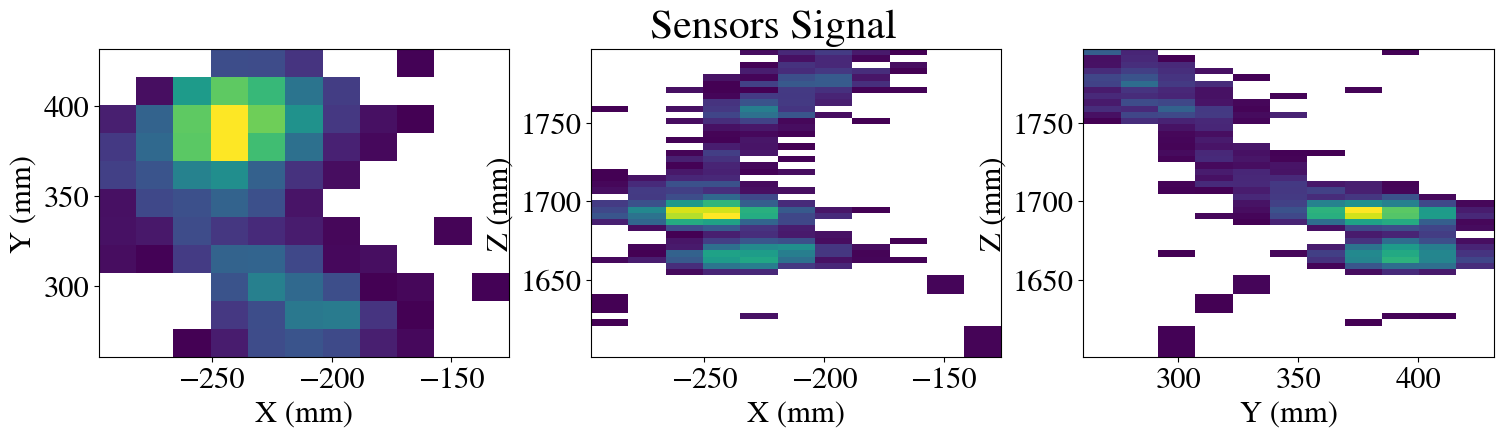

In [22]:
# then applying transformations to convert to 'SiPM outputs'
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
zz = hits.Z.unique()

axes[0].hist2d(hits.X, hits.Y, bins=[xx, yy], weights=hits.Q, cmin=0.0001);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits.X, hits.Z, bins=[xx, zz], weights=hits.Q, cmin=0.0001);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');


axes[2].hist2d(hits.Y, hits.Z, bins=[yy, zz], weights=hits.Q, cmin=0.0001);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');

fig.suptitle('Sensors Signal', fontsize=30)

#### Cut sensors

 Cut sensors below a given threshold, this cleans the signal and removes hits considered not part of the image. It can be seen that the cut does not harm the image noticeably.

In [23]:
qmin = deconv_params['q_cut']
print(f'Cutting sensors below {qmin}')

Cutting sensors below 4


In [24]:
hits_cut = coref.timefunc(cut_sensors)(hits.copy())

Time spent in cut_over_Q: 0.01962423324584961 s


Text(0.5, 0.98, 'Cut Sensors ($q_{cut}$)')

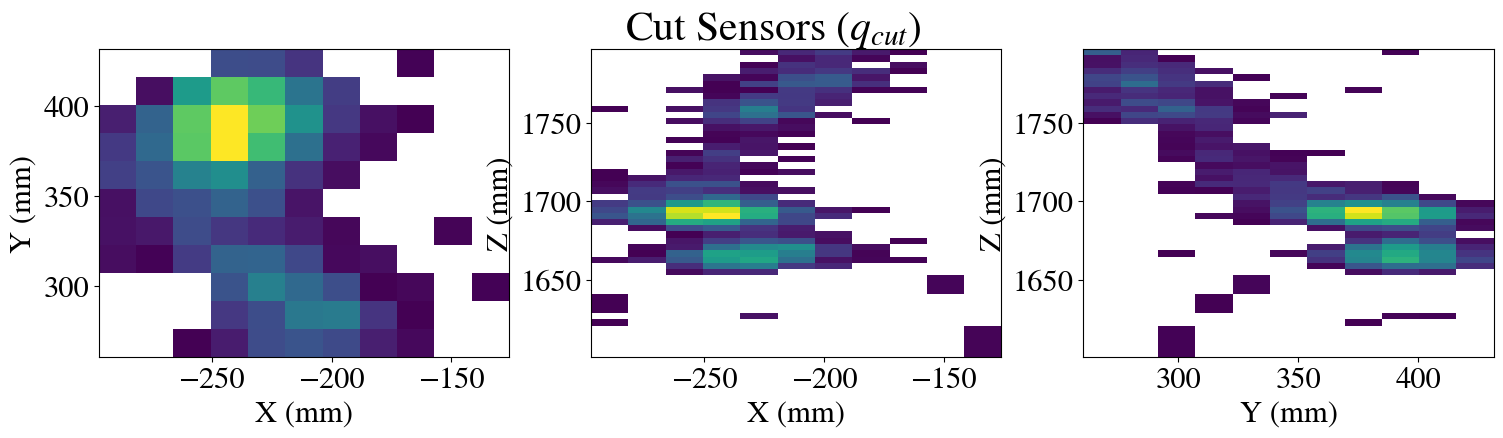

In [25]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
zz = hits.Z.unique()

axes[0].hist2d(hits_cut.X, hits_cut.Y, bins=[xx, yy], weights=hits_cut.Q, cmin=0.0001);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits_cut.X, hits_cut.Z, bins=[xx, zz], weights=hits_cut.Q, cmin=0.0001);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');


axes[2].hist2d(hits_cut.Y, hits_cut.Z, bins=[yy, zz], weights=hits_cut.Q, cmin=0.0001);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');
fig.suptitle('Cut Sensors ($q_{cut}$)', fontsize=30)

Increased cut to see the impact of the function on higher thresholds:

In [26]:
cut_sensors_high = beerfun.cut_over_Q(7, ['E', 'Ec'])
hits_cut_2       = coref.timefunc(cut_sensors_high)(hits.copy())

Time spent in cut_over_Q: 0.01872110366821289 s


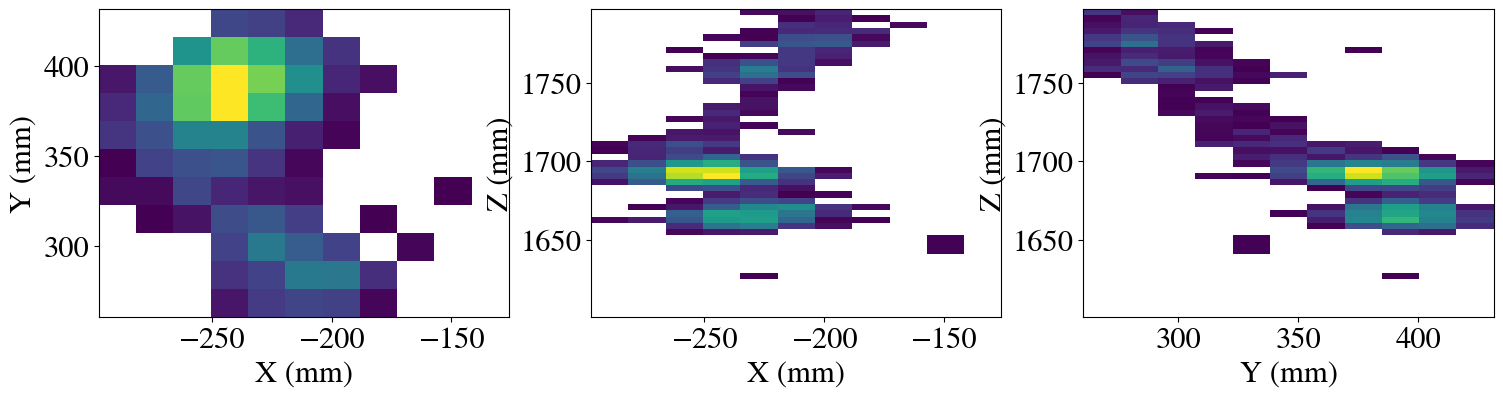

In [27]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
zz = hits.Z.unique()

axes[0].hist2d(hits_cut_2.X, hits_cut_2.Y, bins=[xx, yy], weights=hits_cut_2.Q, cmin=0.0001);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits_cut_2.X, hits_cut_2.Z, bins=[xx, zz], weights=hits_cut_2.Q, cmin=0.0001);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');

axes[2].hist2d(hits_cut_2.Y, hits_cut_2.Z, bins=[yy, zz], weights=hits_cut_2.Q, cmin=0.0001);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');

When cutting, the energy is distributed through the remaining hits so the total energy of the event remains the same:

In [28]:
print(f'Energy (corrected) before cuts:    {hits.E.sum()} ({hits.Ec.sum()})')
print(f'Energy (corrected) after low cut:  {hits_cut.E.sum()} ({hits_cut.Ec.sum()})')
print(f'Energy (corrected) after high cut: {hits_cut_2.E.sum()} ({hits_cut_2.Ec.sum()})')

Energy (corrected) before cuts:    55823.23429100342 (-537.0)
Energy (corrected) after low cut:  55823.23429100342 (-537.0)
Energy (corrected) after high cut: 55823.23429100342 (-536.9999999999999)


#### Drop isolated sensors

Cut sensors that are isolated in XY. Basically drops a sensor if there are no sensors near-by (distance can be configurable) that have seen light in the event.

In [29]:
hits_drop = coref.timefunc(drop_sensors)(hits_cut.copy())

Time spent in drop_isolated: 0.025937795639038086 s


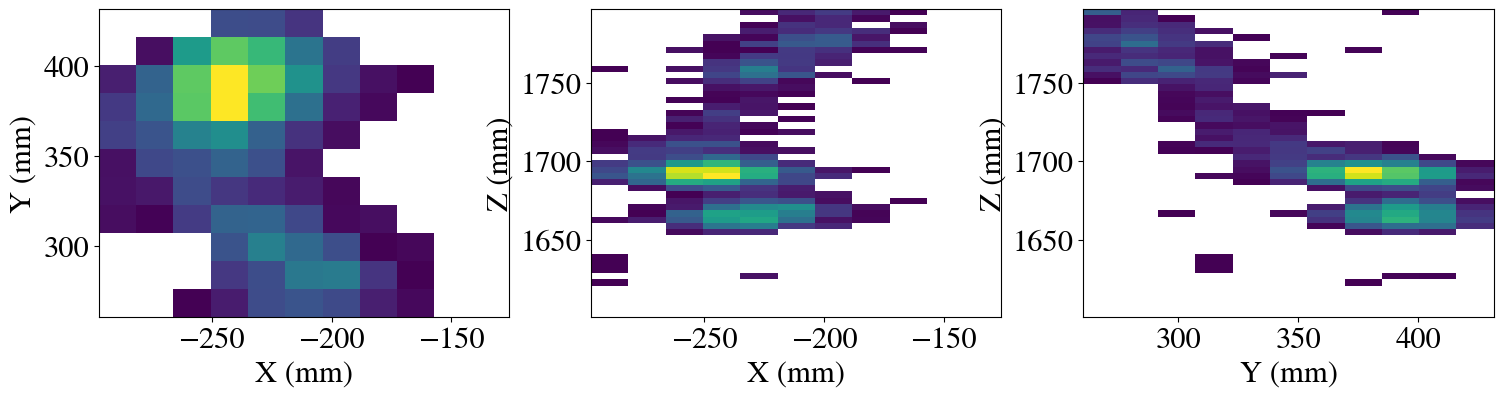

In [30]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

xx = np.arange(hits.X.min(), hits.X.max() + pitch, pitch)
yy = np.arange(hits.Y.min(), hits.Y.max() + pitch, pitch)
zz = hits.Z.unique()

axes[0].hist2d(hits_drop.X, hits_drop.Y, bins=[xx, yy], weights=hits_drop.Q, cmin=0.0001);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits_drop.X, hits_drop.Z, bins=[xx, zz], weights=hits_drop.Q, cmin=0.0001);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');


axes[2].hist2d(hits_drop.Y, hits_drop.Z, bins=[yy, zz], weights=hits_drop.Q, cmin=0.0001);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');


It usually does not make a difference, as it's not usual to have rogue SiPMs. Let's add one and check the performance of the function:

In [31]:
hits_cut.loc[len(hits_cut)] = hits_cut.loc[0].values
hits_cut.loc[len(hits_cut)-1, ['X', 'Y', 'Q']] = [-250, -250, 1000]

In [32]:
hits_cut.tail()

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
533,618469.0,1.730649e+09,0.0,111.0944,12.966709,1.0,-189.175,260.475,0.0,0.0,1796.68200,7.373215,73.052532,-1.0,-1.0,-1.0,-1.0
534,618469.0,1.730649e+09,0.0,111.0944,12.966709,1.0,-189.175,276.025,0.0,0.0,1796.68200,12.445267,123.305542,-1.0,-1.0,-1.0,-1.0
535,618469.0,1.730649e+09,0.0,111.0944,12.966709,1.0,-173.625,276.025,0.0,0.0,1796.68200,6.734721,66.726444,-1.0,-1.0,-1.0,-1.0
536,618469.0,1.730649e+09,0.0,111.0944,12.966709,1.0,-158.075,291.575,0.0,0.0,1796.68200,5.513226,54.624082,-1.0,-1.0,-1.0,-1.0
537,618469.0,1.730649e+09,0.0,111.0944,12.966709,1.0,-250.000,-250.000,0.0,0.0,1600.69275,1000.000000,14.067130,-1.0,-1.0,-1.0,-1.0


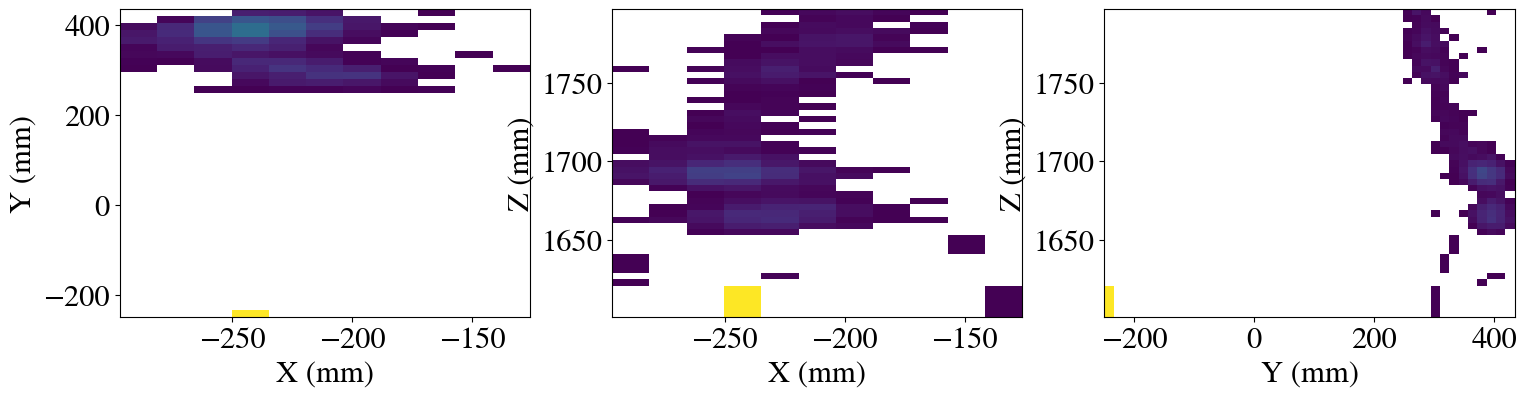

In [33]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

xx = np.arange(hits_cut.X.min(), hits_cut.X.max() + pitch, pitch)
yy = np.arange(hits_cut.Y.min(), hits_cut.Y.max() + pitch, pitch)
zz = hits.Z.unique()

axes[0].hist2d(hits_cut.X, hits_cut.Y, bins=[xx, yy], weights=hits_cut.Q, cmin=0.0001);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits_cut.X, hits_cut.Z, bins=[xx, zz], weights=hits_cut.Q, cmin=0.0001);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');


axes[2].hist2d(hits_cut.Y, hits_cut.Z, bins=[yy, zz], weights=hits_cut.Q, cmin=0.0001);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');



And now after cut:


In [34]:
hits_drop = coref.timefunc(drop_sensors)(hits_cut.copy())

Time spent in drop_isolated: 0.014702081680297852 s


In [35]:
hits_drop.head()

,event,time,npeak,Xpeak,Ypeak,nsipm,X,Y,Xrms,Yrms,Z,Q,E,Qc,Ec,track_id,Ep
0,618469.0,1.730649e+09,0.0,111.0944,12.966709,1.0,-297.025,384.375,0.0,0.0,1620.80550,5.181038,6.602315,-1.0,-1.007491,-1.0,-1.0
1,618469.0,1.730649e+09,0.0,111.0944,12.966709,1.0,-220.275,399.425,0.0,0.0,1624.86200,7.350612,3.792168,-1.0,-1.007491,-1.0,-1.0
2,618469.0,1.730649e+09,0.0,111.0944,12.966709,1.0,-220.275,414.975,0.0,0.0,1624.86200,6.292805,3.246447,-1.0,-1.007491,-1.0,-1.0
3,618469.0,1.730649e+09,0.0,111.0944,12.966709,1.0,-281.475,322.175,0.0,0.0,1628.84425,5.339509,5.971213,-1.0,-1.007491,-1.0,-1.0
4,618469.0,1.730649e+09,0.0,111.0944,12.966709,1.0,-250.375,399.925,0.0,0.0,1653.09700,10.398890,141.723984,-1.0,-1.007491,-1.0,-1.0


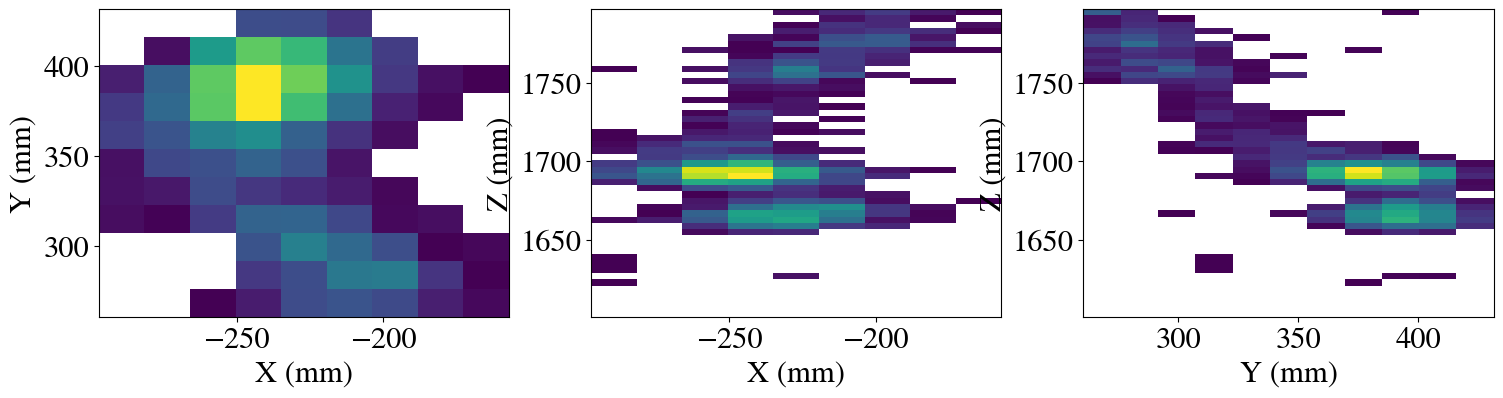

In [36]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

xx = np.arange(hits_drop.X.min(), hits_drop.X.max() + pitch, pitch)
yy = np.arange(hits_drop.Y.min(), hits_drop.Y.max() + pitch, pitch)
zz = hits.Z.unique()

axes[0].hist2d(hits_drop.X, hits_drop.Y, bins=[xx, yy], weights=hits_drop.Q, cmin=0.0001);
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits_drop.X, hits_drop.Z, bins=[xx, zz], weights=hits_drop.Q, cmin=0.0001);
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');


axes[2].hist2d(hits_drop.Y, hits_drop.Z, bins=[yy, zz], weights=hits_drop.Q, cmin=0.0001);
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');

When cutting, the energy is distributed through the reminding hits so the total energy of the event remains the same. The increment is due to the additional hit to hits_copy which caused an increase in the input energy. Still the energy before and after the cut remains the same as should be expected.

In [37]:
print(f'Energy (corrected) before cut: {hits_cut.E.sum()} ({hits_cut.Ec.sum()})')
print(f'Energy (corrected) after  cut: {hits_drop.E.sum()} ({hits_drop.Ec.sum()})')

Energy (corrected) before cut: 55837.301420916556 (-538.0)
Energy (corrected) after  cut: 55837.301420916556 (-537.9999999999999)


Recover the hits as they should (normal cuts):

In [38]:
hits_cut  = coref.timefunc(cut_sensors )(hits    .copy())
hits_drop = coref.timefunc(drop_sensors)(hits_cut.copy())

Time spent in cut_over_Q: 0.01461935043334961 s
Time spent in drop_isolated: 0.02673816680908203 s


### Mid-point, interpolate hits

Using functions from beersheba, should be able to interpolate the hits provided

In [39]:
detector_db     = 'localdb.NEXT100DB.sqlite3'
run_number      = 1 
bin_size        = [ 1,  1]
n_dim           = 2
dimensions      = np.array  (['X', 'Y', 'Z'][:n_dim])
sample_width    = [15.55, 15.55]


det_db = DataSiPM(detector_db, run_number)
inter_method    = InterpolationMethod.cubic
det_grid      = [np.arange(det_db[var].min() + bs/2, det_db[var].max() - bs/2 + np.finfo(np.float32).eps, bs)
                     for var, bs in zip(dimensions, bin_size)]

q = deconvolution_input(sample_width, det_grid, inter_method)


def interp_hits(df, z):
    n_dim = 2
    dimensions      = np.array  (['X', 'Y', 'Z'][:n_dim])
    return(q(tuple(df.loc[:, dimensions].values.T), df.Q.values))

interp_hits = [interp_hits(df_z, z) for z, df_z in hits_drop.groupby("Z")]

In [40]:
print(interp_hits)
print("=====")
print(interp_hits[0])

[(array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), (array([-320.325, -320.325, -320.325, ..., -274.325, -274.325, -274.325]), array([361.675, 362.675, 363.675, ..., 405.675, 406.675, 407.675]))), (array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]]), (array([-243.325, -243.325, -243.325, ..., -197.325, -197.325, -197.325]), array([376.675, 377.675, 378.675, ..., 435.675, 436.675, 437.675]))), (array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., 

NameError: name 'hits_deco' is not defined

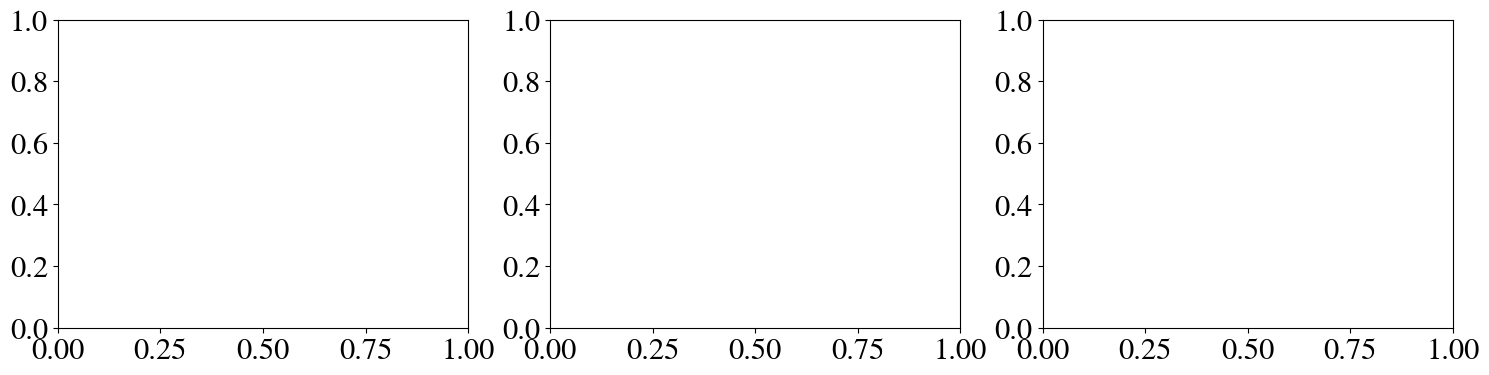

In [41]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

xx = np.arange(hits.X.min(), hits.X.max())
yy = np.arange(hits.Y.min(), hits.Y.max())
zz = hits.Z.unique()

axes[0].hist2d(hits_deco.X, hits_deco.Y, bins=[xx, yy], weights=-hits_deco.E, cmin=0.0001);
if (datatype == 'MC'):
    axes[0].scatter(xt, yt,  alpha=0.1, color='red')
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits_deco.X, hits_deco.Z, bins=[xx, zz], weights=-hits_deco.E, cmin=0.0001);
if (datatype == 'MC'):
    axes[1].scatter(xt, zt,  alpha=0.1, color='red')
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');

axes[2].hist2d(hits_deco.Y, hits_deco.Z, bins=[yy, zz], weights=-hits_deco.E, cmin=0.0001);
if (datatype == 'MC'):
    axes[2].scatter(yt, zt,  alpha=0.1, color='red')
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');

#### Deconvolve Signal 

Last function in the city is deconvolve_signal which basically chooses the deconvolution mode (either 2D or 3D, and joint or separate, see code description) and calls deconvolve function (once per S2 peak). Which first interpolates the signal and then deconvolves it. After all the process, deconvolve_signal assigns the energy, measured by the PMTs (corrected or not, chosen by parameter) to each deconvolved hit based on their fraction of energy of the full S2 peak.

Hereunder, deconvolve_signal output will be showed. Individual performance of each step will be looked into later in the notebook.

In [42]:
deconvolver = beerfun.deconvolve_signal(DataSiPM(detector_db, run_number), **deconv_params_)
hits_deco = coref.timefunc(deconvolver)(hits_drop.copy())

Time spent in apply_deconvolution: 7.269366264343262 s


In [377]:
deconv_params = dict(
  q_cut           = 4, #5 for 6mm  - 5 for 6mm
  drop_dist       = [16, 16],
  #psf_fname       = f'/Users/halmamol/NEXT/PSF_FLEX100_mask{dist}_lowQE.h5',     
  psf_fname       = '/home/e78368jw/Documents/NEXT_CODE/next_misc/0nubb_LPR/LightTables/NEXT100_PSF_kr83m_5bar.h5',     
  e_cut           = 0.25, #15 for 6mm  - 15 for 6mm
  n_iterations    = 30, #150 for 6mm  - 150 for 6mm
  iteration_tol   = 1e-9,
  sample_width    = [15.55, 15.55],
  bin_size        = [ 1,  1],
  diffusion       = (1., 0.2),
  n_dim           = 2,
  deconv_mode     = DeconvolutionMode.joint,
  satellite_params = dict(satellite_start_iter = 5,
                          satellite_max_size   = 100,
                          e_cut                = 0.2,
                          cut_type             = CutType.rel),
  energy_type     = HitEnergy.Ec,
  cut_type        = CutType.rel)
 # inter_method    = InterpolationMethod.cubic)
#satellite_params = dict(satellite_start_iter = 75,
#                        satellite_max_size   = 3,
#                        e_cut                = 0.2,
#                        cut_type             = CutType.rel)
                
deconv_params_   = {k : v for k, v in deconv_params.items() if k not in ['q_cut', 'drop_dist']}

# Couple of functions used in beersheba.

cut_sensors       = beerfun.cut_over_Q   (deconv_params['q_cut'    ], ['E', 'Ec'])
drop_sensors      = beerfun.drop_isolated(deconv_params['drop_dist'], ['E', 'Ec'])

for iterN in np.arange(10, deconv_params_['n_iterations'], 10):
    deconv_params_['n_iterations'] = iterN
    deconvolver = beerfun.deconvolve_signal(DataSiPM(detector_db, run_number), **deconv_params_)
    print(f'{iterN} iterations')
    hits_deco = coref.timefunc(deconvolver)(hits_drop.copy())

10 iterations
Time spent in apply_deconvolution: 2.1262593269348145 s
20 iterations
Time spent in apply_deconvolution: 2.2343175411224365 s


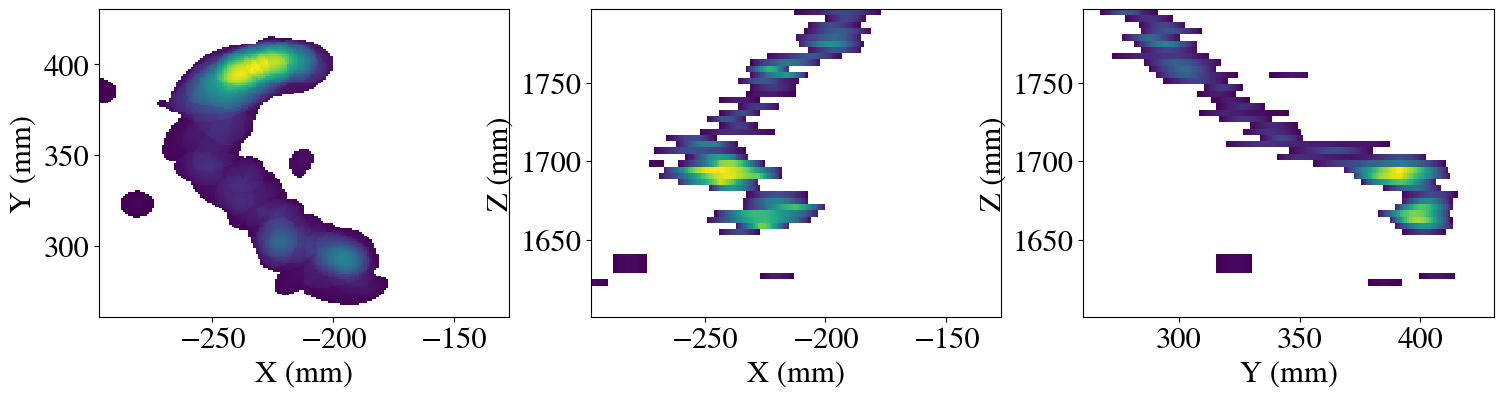

In [378]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

xx = np.arange(hits.X.min(), hits.X.max())
yy = np.arange(hits.Y.min(), hits.Y.max())
zz = hits.Z.unique()


axes[0].hist2d(hits_deco.X, hits_deco.Y, bins=[xx, yy], weights=-hits_deco.E, cmin=0.0001);
if (datatype == 'MC'):
    axes[0].scatter(xt, yt,  alpha=0.1, color='red')
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(hits_deco.X, hits_deco.Z, bins=[xx, zz], weights=-hits_deco.E, cmin=0.0001);
if (datatype == 'MC'):
    axes[1].scatter(xt, zt,  alpha=0.1, color='red')
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');

axes[2].hist2d(hits_deco.Y, hits_deco.Z, bins=[yy, zz], weights=-hits_deco.E, cmin=0.0001);
if (datatype == 'MC'):
    axes[2].scatter(yt, zt,  alpha=0.1, color='red')
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');

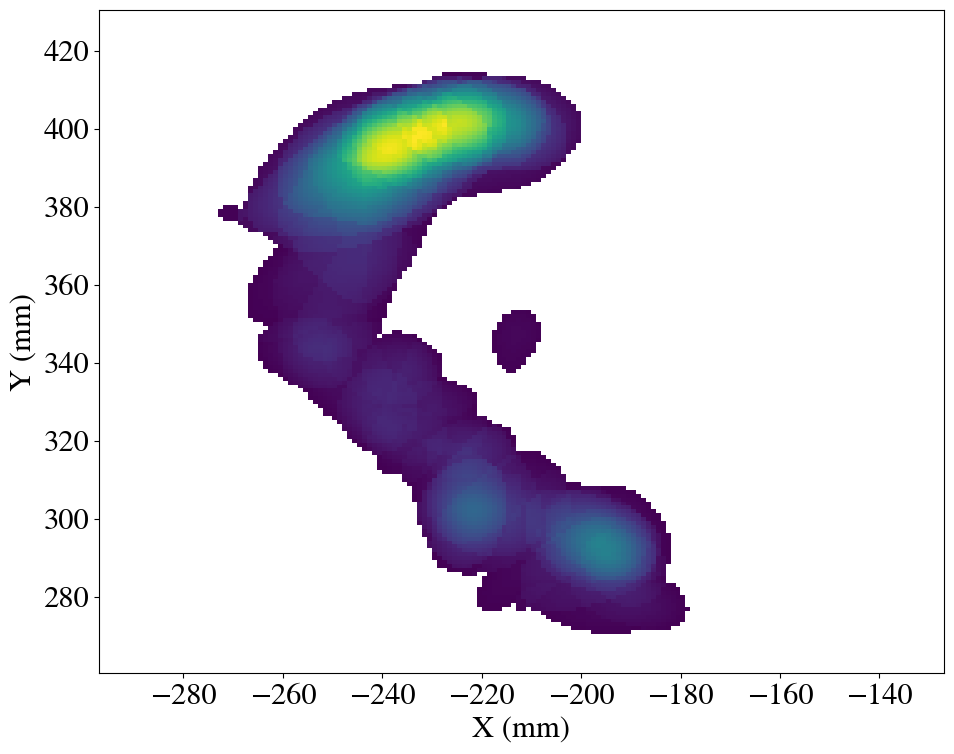

In [379]:


xx = np.arange(hits.X.min(), hits.X.max())
yy = np.arange(hits.Y.min(), hits.Y.max())
zz = hits.Z.unique()


plt.hist2d(hits_deco.X, hits_deco.Y, bins=[xx, yy], weights=-hits_deco.E, cmin=0.01);
if (datatype == 'MC'):
    plt.scatter(xt, yt,  alpha=0.1, color='red')
plt.xlabel('X (mm)');
plt.ylabel('Y (mm)');

plt.tight_layout()
plt.savefig("output/XY-projection.png")


In [380]:
x = hits_deco.X
y = hits_deco.Y
z = hits_deco.Z
e = -hits_deco.E*1000


em = e > 10 # eliminate small things for measurement

#p = ax.scatter(x[em], y[em], z[em], c=e[em], alpha=0.3, cmap='viridis')


display(np.any(hits_deco.E.values > 0))

False

<__array_function__ internals>:180: UserWarning:


/home/e78368jw/anaconda3/envs/IC-3.8-2024-06-08/lib/python3.8/site-packages/matplotlib/colors.py:1159: UserWarning:




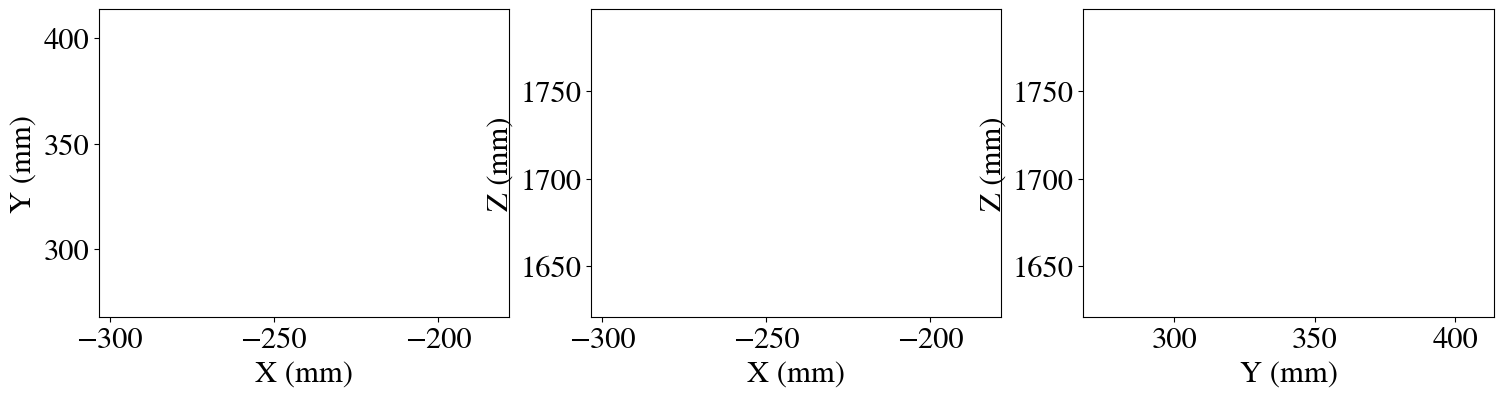

In [381]:
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

xx = np.arange(x.min(), x.max())
yy = np.arange(y.min(), y.max())
zz = z.unique()


axes[0].hist2d(x, y, bins=[xx, yy], weights=-e, cmin=0.0001);
if (datatype == 'MC'):
    axes[0].scatter(xt, yt,  alpha=0.1, color='red')
axes[0].set_xlabel('X (mm)');
axes[0].set_ylabel('Y (mm)');

axes[1].hist2d(x, z, bins=[xx, zz], weights=-e, cmin=0.0001);
if (datatype == 'MC'):
    axes[1].scatter(xt, zt,  alpha=0.1, color='red')
axes[1].set_xlabel('X (mm)');
axes[1].set_ylabel('Z (mm)');

axes[2].hist2d(y, z, bins=[yy, zz], weights=-e, cmin=0.0001);
if (datatype == 'MC'):
    axes[2].scatter(yt, zt,  alpha=0.1, color='red')
axes[2].set_xlabel('Y (mm)');
axes[2].set_ylabel('Z (mm)');

In [382]:
sys.path.append("../../") # if you move files around, you need to adjust this!

import imageio

import re
# human sorting
def tryint(s):
    """
    Return an int if possible, or `s` unchanged.
    """
    try:
        return int(s)
    except ValueError:
        return s

def alphanum_key(s):
    """
    Turn a string into a list of string and number chunks.

    >>> alphanum_key("z23a")
    ["z", 23, "a"]

    """
    return [ tryint(c) for c in re.split('([0-9]+)', s) ]

def human_sort(l):
    """
    Sort a list in the way that humans expect.
    """
    l.sort(key=alphanum_key)



In [383]:
print(x)

0       -303.325
1       -303.325
2       -303.325
3       -303.325
4       -303.325
          ...   
21764   -177.325
21765   -177.325
21766   -177.325
21767   -177.325
21768   -177.325
Name: X, Length: 21769, dtype: float64


In [384]:
em = e > 2 # eliminate small things for measurement


In [385]:
'''
x_plot = x[em].to_numpy()
y_plot = y[em].to_numpy()
z_plot = z[em].to_numpy()
e_plot = e[em].to_numpy()

# Create a regular grid in 3D space
grid_x, grid_y, grid_z = np.mgrid[
    min(x_plot):max(x_plot):20j,  # 20 steps in X
    min(y_plot):max(y_plot):20j,  # 20 steps in Y
    min(z_plot):max(z_plot):20j   # 20 steps in Z
]

# Interpolate energy values onto the grid
energy_grid = griddata(
    (x_plot, y_plot, z_plot), e_plot, (grid_x, grid_y, grid_z), method='linear', fill_value=5
)


# Flatten arrays for Plotly
fig = go.Figure(data=go.Volume(
    x=grid_x.flatten(),
    y=grid_y.flatten(),
    z=grid_z.flatten(),
    value=energy_grid.flatten(),
    opacity=0.5,
    surface_count=100,
    isomin=20,
    isomax = 50,
    colorscale="inferno"
))

fig.update_layout(
    title="3D Volumetric Energy Track",
    scene=dict(xaxis_title="X", yaxis_title="Y", zaxis_title="Z")
)

fig.show()
'''

'\nx_plot = x[em].to_numpy()\ny_plot = y[em].to_numpy()\nz_plot = z[em].to_numpy()\ne_plot = e[em].to_numpy()\n\n# Create a regular grid in 3D space\ngrid_x, grid_y, grid_z = np.mgrid[\n    min(x_plot):max(x_plot):20j,  # 20 steps in X\n    min(y_plot):max(y_plot):20j,  # 20 steps in Y\n    min(z_plot):max(z_plot):20j   # 20 steps in Z\n]\n\n# Interpolate energy values onto the grid\nenergy_grid = griddata(\n    (x_plot, y_plot, z_plot), e_plot, (grid_x, grid_y, grid_z), method=\'linear\', fill_value=5\n)\n\n\n# Flatten arrays for Plotly\nfig = go.Figure(data=go.Volume(\n    x=grid_x.flatten(),\n    y=grid_y.flatten(),\n    z=grid_z.flatten(),\n    value=energy_grid.flatten(),\n    opacity=0.5,\n    surface_count=100,\n    isomin=20,\n    isomax = 50,\n    colorscale="inferno"\n))\n\nfig.update_layout(\n    title="3D Volumetric Energy Track",\n    scene=dict(xaxis_title="X", yaxis_title="Y", zaxis_title="Z")\n)\n\nfig.show()\n'

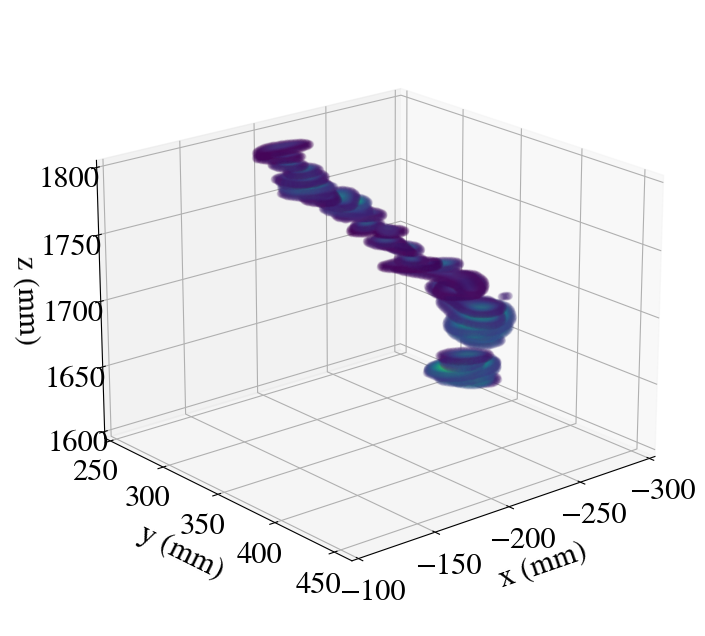

In [395]:
from matplotlib import colors

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')


# annihilate deposits under y = 1650
xq = x[em]
yq = y[em]
zq = z[em]
eq = e[em]

ym = z > 1650

p = ax.scatter(xq[ym], yq[ym], zq[ym], c=eq[ym], alpha=0.08, cmap='viridis')
#p = ax.scatter(x, y, z, c=e, alpha=0.3, cmap='viridis')
#cb = fig.colorbar(p, ax=ax)
#cb.set_label('Energy (keV)')


ax.set_xlabel('\nx (mm)')
ax.set_ylabel('\ny (mm)')
ax.set_zlabel('\nz (mm)')

ax.set_xlim([-300, -100])
ax.set_ylim([249, 460])
ax.set_zlim([1800, 1650])

ax.view_init(20, 50)

plt.show()

In [396]:
rotation = True
if rotation==True:
  rotation_space = np.linspace(0, 359, 180, endpoint = True)

  for i in (rotation_space):
    fig = plt.figure()
    fig.suptitle('3D event ' + str(evt), fontsize=30)
    ax = fig.add_subplot(111, projection='3d')
    #em = e > 0.00005 # eliminate small things for measurement
    #p = ax.scatter(x[em], y[em], z[em], c=e[em], alpha=0.3, cmap='viridis')
    #plt_sphere([(-track.blob2_x.values[0], -track.blob2_y.values[0], -track.blob2_z.values[0])], [blobR])
    #p = ax.scatter(x[em], y[em], z[em], c=e[em], alpha=0.08, cmap='viridis')
    p = ax.scatter(xq[ym], yq[ym], zq[ym], c=eq[ym], alpha=0.08, cmap='viridis')

    # overlay the blobs and their radii

    #cb = fig.colorbar(p, ax=ax)
    #cb.set_label('Energy (keV)')
    ax.set_xlabel('\nx (mm)')
    ax.set_ylabel('\ny (mm)')
    ax.set_zlabel('\nz (mm)')
    

    ax.set_xlim([-300, -100])
    ax.set_ylim([249, 460])
    ax.set_zlim([1599, 1801])


    ax.view_init(20, -i)
    plt.savefig(f'gif_making/deconv/angle_{i}.png')
    plt.close(fig)

In [397]:
if rotation == True:
    
    files = [f for f in os.listdir('gif_making/deconv/') if os.path.isfile(os.path.join('gif_making/deconv/', f))]

    #sort files in a human manner
    files.sort(key=alphanum_key)
    images = []
    for filename in files:
        images.append(imageio.imread('gif_making/deconv/' + filename))
    

    print("Creating gif...")
    gif_name = f'output/rotating_track_evt_{evt}.gif'
    imageio.mimsave(gif_name, images, loop = 0, fps = 20)


/tmp/ipykernel_35706/520303222.py:9: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.



Creating gif...


/tmp/ipykernel_35706/464031582.py:75: MatplotlibDeprecationWarning:

Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().



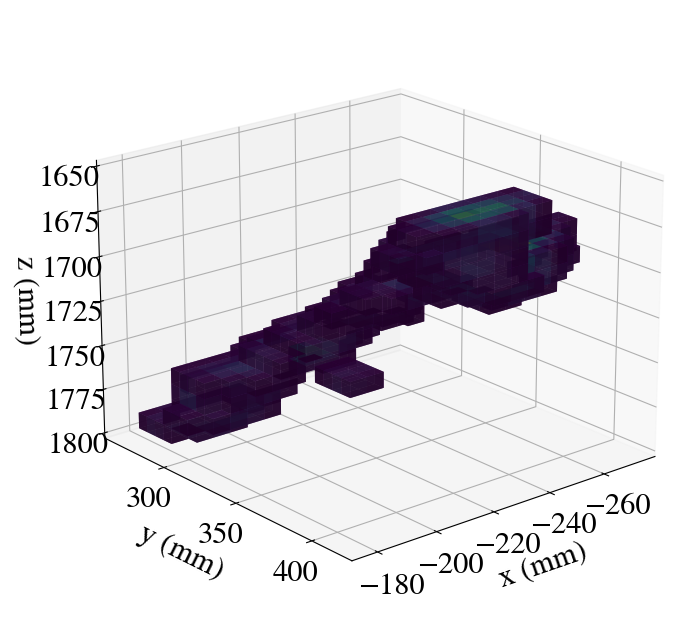

In [458]:
from matplotlib.colors import LogNorm
import seaborn as sns
from matplotlib.colors import ListedColormap
base_vsize = 7.5 #mm
the_hits = []

xs = hits_deco.X
ys = hits_deco.Y
zs = hits_deco.Z
es = -hits_deco.E*1000

esm = es > 5

# annihilate deposits under y = 1650
xq = xs[esm]
yq = ys[esm]
zq = zs[esm]
eq = es[esm]

ym = zq > 1650


for x, y, z, e in zip(xq[ym], yq[ym], zq[ym], eq[ym]):
    if np.isnan(e): continue
    h = Hit(0, Cluster(0, xy(x,y), xy(0,0), 0), z, e*1000, xy(0,0))
    the_hits.append(h)

voxels = voxelize_hits(the_hits,
                       np.array([6, 6, 9]), False)

vsizex = voxels[0].size[0]
vsizey = voxels[0].size[1]
vsizez = voxels[0].size[2]

min_corner_x = min(v.X for v in voxels) - vsizex/2.
min_corner_y = min(v.Y for v in voxels) - vsizey/2.
min_corner_z = min(v.Z for v in voxels) - vsizez/2.

x = [np.round(v.X/vsizex) for v in voxels]
y = [np.round(v.Y/vsizey) for v in voxels]
z = [np.round(v.Z/vsizez) for v in voxels]
e = np.array([v.E for v in voxels])

x_min = int(min(x))
y_min = int(min(y))
z_min = int(min(z))

x_max = int(max(x))
y_max = int(max(y))
z_max = int(max(z))

#print(f'X min = {x_min}, X max = {x_max}')
#print(f'Y min = {y_min}, Y max = {y_max}')
#print(f'Z min = {z_min}, Z max = {z_max}')

VOXELS = np.zeros((x_max-x_min+1, y_max-y_min+1, z_max-z_min+1))
#print(VOXELS.shape)

# sort through the event set the "turn on" the hit voxels
my_cmap = ListedColormap(sns.color_palette('rocket').as_hex())
cmap = cm.viridis
#cmap = my_cmap
#norm = LogNorm(vmin=np.min(e[e > 10000]), vmax=np.max(e))  # Apply LogNorm
norm = Normalize(vmin=0, vmax=max(e))


colors = np.empty(VOXELS.shape, dtype=object)
for q in range(0,len(z)):
    VOXELS[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = 1
    colors[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = cmap(norm(e[q]))


# and plot everything
fig = plt.figure(figsize=(8,8))
ax = fig.gca(projection='3d')
#a,b,c is spacing in mm needs an extra dim
a,b,c = np.indices((x_max-x_min+2, y_max-y_min+2, z_max-z_min+2))
a = a*vsizex + min_corner_x
b = b*vsizey + min_corner_y
c = c*vsizez + min_corner_z

# a, b, c are the corners of the voxels


ax.voxels(a,b,c, VOXELS, facecolors=colors,alpha=0.8)



ax.set_xlabel('\nx (mm)')
ax.set_ylabel('\ny (mm)')
ax.set_zlabel('\nz (mm)')

#ax.set_xlim([-300, -100])
#ax.set_ylim([249, 460])
ax.set_zlim([1800, 1650])

#sm = cm.ScalarMappable(cmap=cmap, norm=norm)
#sm.set_array([])
#cb = fig.colorbar(sm)
#cb.set_label('Energy (keV)')
ax.view_init(20, 50)
plt.show()

In [459]:
if rotation==True:
  rotation_space = np.linspace(0, 359, 180, endpoint = True)

  for i in (rotation_space):

        the_hits = []
        
        xs = hits_deco.X
        ys = hits_deco.Y
        zs = hits_deco.Z
        es = -hits_deco.E*1000
        
        esm = es > 5
        
        # annihilate deposits under y = 1650
        xq = xs[esm]
        yq = ys[esm]
        zq = zs[esm]
        eq = es[esm]
        
        ym = zq > 1650
        
        
        for x, y, z, e in zip(xq[ym], yq[ym], zq[ym], eq[ym]):
            if np.isnan(e): continue
            h = Hit(0, Cluster(0, xy(x,y), xy(0,0), 0), z, e*1000, xy(0,0))
            the_hits.append(h)
        
        voxels = voxelize_hits(the_hits,
                               np.array([6, 6, 9]), False)
        
        vsizex = voxels[0].size[0]
        vsizey = voxels[0].size[1]
        vsizez = voxels[0].size[2]
        
        min_corner_x = min(v.X for v in voxels) - vsizex/2.
        min_corner_y = min(v.Y for v in voxels) - vsizey/2.
        min_corner_z = min(v.Z for v in voxels) - vsizez/2.
        
        x = [np.round(v.X/vsizex) for v in voxels]
        y = [np.round(v.Y/vsizey) for v in voxels]
        z = [np.round(v.Z/vsizez) for v in voxels]
        e = np.array([v.E for v in voxels])
        
        x_min = int(min(x))
        y_min = int(min(y))
        z_min = int(min(z))
        
        x_max = int(max(x))
        y_max = int(max(y))
        z_max = int(max(z))
        
        #print(f'X min = {x_min}, X max = {x_max}')
        #print(f'Y min = {y_min}, Y max = {y_max}')
        #print(f'Z min = {z_min}, Z max = {z_max}')
        
        VOXELS = np.zeros((x_max-x_min+1, y_max-y_min+1, z_max-z_min+1))
        #print(VOXELS.shape)
        
        # sort through the event set the "turn on" the hit voxels
        cmap = cm.viridis
        #norm = LogNorm(vmin=np.min(e[e > 0]), vmax=np.max(e))  # Apply LogNorm
        norm = Normalize(vmin=0, vmax=max(e))
        
        
        colors = np.empty(VOXELS.shape, dtype=object)
        for q in range(0,len(z)):
            VOXELS[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = 1
            colors[int(x[q])-x_min][int(y[q])-y_min][int(z[q])-z_min] = cmap(norm(e[q]))
        
        
        # and plot everything
        fig = plt.figure(figsize=(8,8))
        ax = fig.gca(projection='3d')
        #a,b,c is spacing in mm needs an extra dim
        a,b,c = np.indices((x_max-x_min+2, y_max-y_min+2, z_max-z_min+2))
        a = a*vsizex + min_corner_x
        b = b*vsizey + min_corner_y
        c = c*vsizez + min_corner_z
        
        # a, b, c are the corners of the voxels
        ax.voxels(a,b,c, VOXELS, facecolors=colors,alpha=0.9)
        
        
        
        ax.set_xlabel('\nx (mm)')
        ax.set_ylabel('\ny (mm)')
        ax.set_zlabel('\nz (mm)')
        
        #ax.set_xlim([-300, -100])
        #ax.set_ylim([249, 460])
        ax.set_zlim([1800, 1650])
        ax.view_init(20, -i)
        plt.savefig(f'gif_making_voxel/deconv/angle_{i}.png')
        plt.close(fig)

/tmp/ipykernel_35706/2256671932.py:74: MatplotlibDeprecationWarning:

Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().



In [461]:
if rotation == True:
    
    files = [f for f in os.listdir('gif_making_voxel/deconv/') if os.path.isfile(os.path.join('gif_making_voxel/deconv/', f))]

    #sort files in a human manner
    files.sort(key=alphanum_key)
    images = []
    for filename in files:
        images.append(imageio.imread('gif_making_voxel/deconv/' + filename))
    

    print("Creating gif...")
    gif_name = f'output/rotating_track_evt_voxel_{evt}.gif'
    imageio.mimsave(gif_name, images, loop = 0, fps = 20)

/tmp/ipykernel_35706/2152108157.py:9: DeprecationWarning:

Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.



Creating gif...


In [37]:
hits_deco.head()

,event,npeak,X,Y,Z,E,Xpeak,Ypeak
0,618469,0,-243.325,376.675,1624.862,-1.959099e-14,111.0944,12.966709
1,618469,0,-243.325,377.675,1624.862,-5.524125e-14,111.0944,12.966709
2,618469,0,-243.325,378.675,1624.862,-1.499295e-13,111.0944,12.966709
3,618469,0,-243.325,379.675,1624.862,-3.915230e-13,111.0944,12.966709
4,618469,0,-243.325,380.675,1624.862,-9.851004e-13,111.0944,12.966709


In [401]:

def plot_hits_voxelized(hits):
    nx = hits.X.unique().size//4
    ny = hits.Y.unique().size//4
    nz = hits.Z.unique().size//1

    e, (z,x,y) = np.histogramdd(hits.filter(list("ZXY")).values, (nz, nx, ny), weights=hits.E)
    z,x,y = np.meshgrid(z,x,y, indexing="ij")

    mapper = cm.ScalarMappable(cmap=cm.gnuplot2_r)
    colors = mapper.to_rgba(e.flatten()/e.max(), alpha=0.5).reshape(e.shape + (4,))

    plt.ion()
    ax = plt.figure(figsize=(10,8)).add_subplot(projection='3d')
    ax.voxels(z, x, y, e,
              facecolors=colors,
              edgecolors=colors,
              linewidth=0.5)
    ax.set_xlabel("z (mm)", labelpad=50)
    ax.set_ylabel("x (mm)", labelpad=50)
    ax.set_zlabel("y (mm)", labelpad=50)